# Conversational agent based on a seq2seq model with attention

## Setup environment if running in Google Colab

In [1]:
# %%bash
# git clone https://github.com/Paulescu/talking-machines.git
# mv talking-machines/* .
# rm -r talking-machines
# pip install -q -r requirements_py3.6.txt

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

## Set environment variables

In [23]:
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    print('Running in Colab')

    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')

    STORAGE_DIR = Path('/content/drive/MyDrive/chatbot-course')
else:
    print('Running in local')
    STORAGE_DIR = Path('.')
    
DATA_DIR = STORAGE_DIR / 'data'
ARTIFACTS_DIR = STORAGE_DIR / 'artifacts'
VECTORS_CACHE_DIR = STORAGE_DIR / 'vector_cache'

Running in local


In [8]:
import torch

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print('GPU acceleration is available and will be used :-)')
else:
    DEVICE = torch.device("cpu")
    print('GPU is not available. If you are using Google Colab, change the runtime to GPU, otherwise training will '
          'take too long.')

GPU is not available. If you are using Google Colab, change the runtime to GPU, otherwise training will take too long.


## Download the data

In [22]:
# !wget http://parl.ai/downloads/personachat/personachat.tgz -P $DATA_DIR
# !tar -tvf ${DATA_DIR}/personachat.tgz -C ${DATA_DIR}

tar: Error opening archive: Failed to open '/personachat/personachat.tgz'


In [15]:
DATA_DIR = DATA_DIR / 'personachat'

------

## Generate train, val, test files with pairs of sentences *(source, target)*

In [24]:
%autoreload 2
from utils.data import generate_file_with_sentence_pairs

# train set
generate_file_with_sentence_pairs(
    input_file=DATA_DIR/'train_none_original.txt',
    output_file=DATA_DIR/'train_none_original.csv',
#     n_past_utterances=1,
    autocorrect=False,
)

# validation set
generate_file_with_sentence_pairs(
    input_file=DATA_DIR/'valid_none_original.txt',
    output_file=DATA_DIR/'valid_none_original.csv',
    autocorrect=False,
)

# test set
generate_file_with_sentence_pairs(
    input_file=DATA_DIR/'test_none_original.txt',
    output_file=DATA_DIR/'test_none_original.csv',
    autocorrect=False,
)

Generated data/train_none_original.csv
Generated data/valid_none_original.csv
Generated data/test_none_original.csv


----

## Generate the vocabulary

I use all data available in the train set to build the vocab.

I want to keep the vocab fixed while I play with different train sub-datasets

In [25]:
%autoreload 2
from utils.data import get_sentence_processor

sentence_processor = get_sentence_processor(
    train_file=DATA_DIR/'train_none_original.csv',
    min_word_freq=1,
    max_vocab_size=99999,
    use_glove_vectors=True,
    vectors_cache=VECTORS_CACHE_DIR,
)
print(f'{len(sentence_processor.vocab):,} words in the vocabulary.')

from utils.util import save_vocab
vocab = sentence_processor.vocab
save_vocab(
    sentence_processor.vocab,
    ARTIFACTS_DIR/f'vocab_{len(vocab)}.pkl'
)
print('Vocabulary saved.')

/Users/paulabartabajo/miniconda3/envs/chatbot_py3.6/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/Users/paulabartabajo/miniconda3/envs/chatbot_py3.6/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


18,674 words in the vocabulary.
Vocabulary saved.


--------

## Quick exploratory data analysis

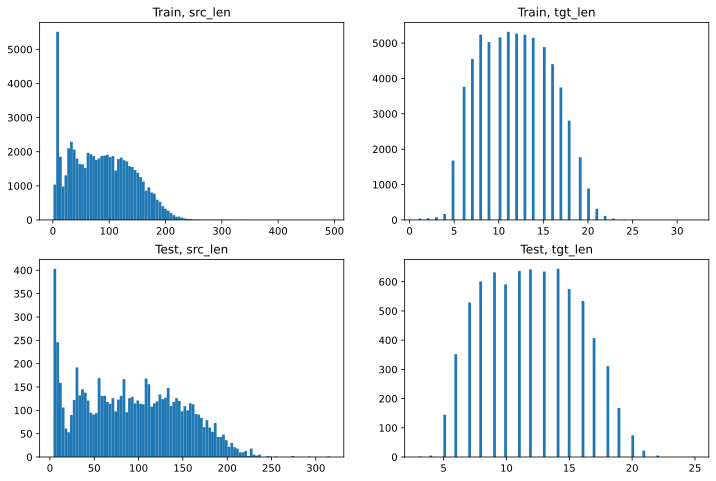

In [26]:
%autoreload 2
from utils.util import plot_sentence_lengths

plot_sentence_lengths(
    train_file=DATA_DIR/'train_none_original.csv',
    test_file=DATA_DIR/'test_none_original.csv',
)

In [31]:
# print(vocab.stoi['hdfsi'])
# print(vocab.stoi['<PAD>'])
# print(vocab.stoi['<BOS>'])
# print(vocab.stoi['<EOS>'])
# print(vocab.stoi['hi'])
# print(vocab.vectors[0])
# print(vocab.vectors[1])
# print(vocab.vectors[2])
# print(vocab.vectors[3])
# print(vocab.vectors[vocab.stoi['hi']])

## PyTorch datasets

In [40]:
%autoreload 2
from utils.data import get_datasets

train_ds, val_ds, test_ds = get_datasets(
    path=DATA_DIR,
    train='train_none_original.csv',
    val='valid_none_original.csv',
    test='test_none_original.csv',
    sentence_processor=sentence_processor,
    train_size=1000,
)

print(f'{len(train_ds):,}')
print(f'{len(val_ds):,}')
print(f'{len(test_ds):,}')

1,000
7,801
7,512


## PyTorch DataLoaders

In [41]:
%autoreload 2
from utils.data import get_dataloaders

train_iter, validation_iter, test_iter = get_dataloaders(
    train_ds, val_ds, test_ds,
    batch_size=64,
    device=DEVICE
)

x = next(iter(train_iter))
print('Example \n-------')
print(x.src[0].shape)
print(x.src[0])
print(x.src[1])

Example 
-------
torch.Size([64, 125])
tensor([[  2, 284,  40,  ...,   3,   1,   1],
        [  2,  43,   8,  ...,   1,   1,   1],
        [  2,  32,  21,  ...,  41,  26,   3],
        ...,
        [  2,  32,  13,  ...,   1,   1,   1],
        [  2,  32,   8,  ...,   1,   1,   1],
        [  2,  32,  15,  ...,   1,   1,   1]])
tensor([123, 122, 125, 124, 123, 123, 122, 123, 122, 125, 124, 124, 125, 123,
        122, 122, 121, 120, 120, 120, 120, 119, 119, 121, 121, 121, 121, 121,
        120, 120, 120, 119, 118, 117, 116, 116, 117, 117, 117, 116, 114, 114,
        117, 116, 117, 117, 114, 115, 115, 114, 114, 114, 114, 119, 118, 117,
        115, 113, 113, 109, 106, 107, 107, 106])


## Model

In [42]:
%autoreload 2
from model import Seq2seqRNN
from utils.util import count_parameters
from utils.data import PAD_TOKEN

vocab = sentence_processor.vocab
model = Seq2seqRNN(vocab_size=len(vocab),
                   embedding_dim=vocab.vectors.shape[1],
                   hidden_dim=128,
                   n_layers=2,
                   n_directions_encoder=1,
                   padding_idx=vocab.stoi[PAD_TOKEN],
                   device=DEVICE,
                   dropout=0.1,
                   pretrained_embeddings=vocab.vectors,
#                    freeze_embeddings=False,
#                    attention_type='dot'
                  )

print(f'The model has {count_parameters(model):,} parameters')

The model has 8,715,658 parameters


## Train

In [43]:
%autoreload 2
from train import Seq2seqRNNTrainer
from utils.data import PAD_TOKEN

trainer = Seq2seqRNNTrainer(model,
                            train_iter,
                            validation_iter,
                            learning_rate=1,
                            pad_token_id=vocab.stoi[PAD_TOKEN],
                            gradient_clip=0.1,
                            teacher_forcing=0.1,
                            checkpoint_dir=ARTIFACTS_DIR,
                            validate_every_n_sec=30)
epochs = 10
trainer.train(epochs)

Epoch 0 Batch: 1/16 Loss: 9.8368 Perplexity: 18708.94 lr: 1.0000
Epoch 0 Batch: 2/16 Loss: 28.5550 Perplexity: 2519231991788.70 lr: 1.0000
Epoch 0 Batch: 3/16 Loss: 27.5752 Perplexity: 945694338940.88 lr: 1.0000
Validating model performance...


KeyboardInterrupt: 

## In case you want to resume training from a saved checkpoint

In [127]:
run_id = '116f63f4-6ab8-11eb-a582-acbc32b70c09'
trainer.load(run_id=run_id, epoch=9)

n_epochs = 10
trainer.train_test_loop(n_epochs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 000, Train loss: 4.6936, Val loss: 4.5945, Train ppl: 109.3, Val ppl: 98.9
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/9.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 001, Train loss: 4.6872, Val loss: 4.5905, Train ppl: 108.6, Val ppl: 98.5
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/10.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 002, Train loss: 4.6767, Val loss: 4.5925, Train ppl: 107.4, Val ppl: 98.7


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 003, Train loss: 4.6707, Val loss: 4.5887, Train ppl: 106.8, Val ppl: 98.4
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/12.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 004, Train loss: 4.6637, Val loss: 4.5880, Train ppl: 106.0, Val ppl: 98.3
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/13.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 005, Train loss: 4.6581, Val loss: 4.5776, Train ppl: 105.4, Val ppl: 97.3
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/14.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 006, Train loss: 4.6563, Val loss: 4.5849, Train ppl: 105.2, Val ppl: 98.0


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 007, Train loss: 4.6507, Val loss: 4.5755, Train ppl: 104.7, Val ppl: 97.1
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/16.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 008, Train loss: 4.6474, Val loss: 4.5824, Train ppl: 104.3, Val ppl: 97.8


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 009, Train loss: 4.6414, Val loss: 4.5735, Train ppl: 103.7, Val ppl: 96.9
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/18.ckpt was saved
artifacts/116f63f4-6ab8-11eb-a582-acbc32b70c09/params.json file was saved
